In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple

/opt/anaconda3/envs/pytorch_unet/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/pytorch_unet/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/pytorch_unet/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <85021449-F141-385B-8151-410662B4D328> /opt/anaconda3/envs/pytorch_unet/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
history_size = 96
predict_size = 96 
input_size = 1
hidden_size = 256
n_layers = 16
n_epoch = 3
lr = 0.01

train_split = 4000

In [3]:
class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        x = x + self.mean
        return x

In [4]:
class LSTMCell(nn.Module):
    def __init__(self, input_size : int, hidden_size : int):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.hidden_lin = nn.Linear(hidden_size, 4 * hidden_size)
        self.input_lin = nn.Linear(input_size, 4 * hidden_size, bias=False)

    def forward(self, x, h_in, c_in):
        X = self.input_lin(x) + self.hidden_lin(h_in) # 입력과 은닉 상태를 선형 변환 후 더함
        i, f, g, o = X.chunk(4, dim=-1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        c_next = c_in * f + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, n_layers: int, use_RevIN: bool):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.use_Revin = use_RevIN
        self.cells = nn.ModuleList(
            [LSTMCell(input_size=input_size, hidden_size=hidden_size)] +
            [LSTMCell(input_size=hidden_size, hidden_size=hidden_size) for _ in range(n_layers - 1)]
        )
        self.linear = nn.Linear(self.hidden_size, 1)
        self.revin = RevIN(1)

    def forward(self, x: torch.Tensor, state: Optional[Tuple[torch.Tensor, torch.Tensor]] = None):
        batch_size, seq_len, _ = x.shape
        if self.use_Revin:
            x = self.revin(x, "norm")

        if state is None:
            h = [x.new_zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]
            c = [x.new_zeros(batch_size, self.hidden_size) for _ in range(self.n_layers)]
        else:
            h, c = state
            h, c = list(torch.unbind(h)), list(torch.unbind(c))

        outputs = []  # 각 time step의 출력을 담는 리스트
        for t in range(seq_len):
            inp = x[:, t, :]  # 각 시점의 입력
            for layer in range(self.n_layers):
                h[layer], c[layer] = self.cells[layer](inp, h[layer], c[layer])
                inp = h[layer]
            outputs.append(self.linear(h[-1]))  # 각 time step에서 마지막 layer의 hidden state를 사용해 예측
        outputs = torch.stack(outputs, dim=1).squeeze(0)  # 모든 time step의 예측을 쌓음

        if self.use_Revin:
            outputs = self.revin(outputs, "denorm").squeeze(0)

        h = torch.stack(h)
        c = torch.stack(c)


        return outputs[-predict_size:], (h, c)


In [6]:
data_csv = pd.read_csv("../dataset/gc19_a.csv")
uni_data = data_csv['avgcpu']
#uni_data.index = data_csv['time'] # index로 매핑

uni_data[0]

0.3824352530708969

In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size, step, single_step=False):
    datas = []
    labels = []

    start_index = start_index + history_size

    if end_index == None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        datas.append(np.reshape(dataset[indices], (history_size,1)))

        if single_step: # 단기 예측
            labels.append(dataset[i + target_size])
        else: # 장기 예측
            labels.append(dataset[i:i + target_size])

    return np.array(datas), np.array(labels)

def multivariate_data(dataset, start_index, end_index, history_size, target_size, step, single_step=False):
    datas = []
    labels = []

    start_index = start_index + history_size

    if end_index == None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        datas.append(dataset[indices])

        if single_step: # 단기 예측
            labels.append(dataset[i + target_size])
        else: # 장기 예측
            labels.append(dataset[i:i + target_size])

    return np.array(datas), np.array(labels)

In [8]:
x_train_uni, y_train_uni = univariate_data(uni_data, 0, train_split, history_size, predict_size, 1, False)
x_test_uni, y_test_uni = univariate_data(uni_data, train_split, None, history_size, predict_size, 1, False)

In [9]:
def create_time_steps(length):
    if length >= 0:
        return range(0, length)
    else:
        return range(length, 0)

def show_plot(plot_data, delta, title):
    labels = ["history", "true future", "baseline"]
    marker = ["-", "r-", "g-"]
    time_steps = create_time_steps(-plot_data[0].shape[0])
    if delta: future = delta
    else: future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(create_time_steps(x.shape[0]), plot_data[i], marker[i], label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])

    plt.legend()
    plt.axis('auto')
    plt.xlabel('time-steps')
    return plt

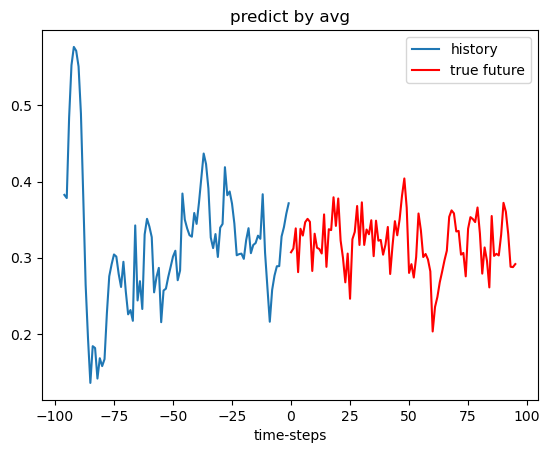

In [10]:
show_plot([x_train_uni[0], y_train_uni[0]], predict_size, "predict by avg").show()

In [11]:
model = LSTM(input_size=input_size, hidden_size=hidden_size, n_layers=n_layers, use_RevIN=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

In [12]:
# x_train_uni = DataLoader(dataset=torch.tensor(x_train_uni, dtype=torch.float), batch_size=100, num_workers=2, shuffle=False)
# y_train_uni = DataLoader(dataset=torch.tensor(y_train_uni, dtype=torch.float), batch_size=100, num_workers=2, shuffle=False)

x_train_uni = torch.tensor(x_train_uni, dtype=torch.float)
y_train_uni = torch.tensor(y_train_uni, dtype=torch.float)

x_train_uni.shape

torch.Size([3904, 96, 1])

In [13]:
torch.autograd.set_detect_anomaly(True)

def train(X, Y, model, criterion, optimizer, epoch):
    model.train()

    for ep in range(epoch):
        h, c = None, None  # 초기화
        for batch, data in enumerate(X):
            optimizer.zero_grad()
            data = data.unsqueeze(0)
            # 이전 배치에서 hidden state와 cell state가 있으면 detach()
            if h is not None and c is not None:
                h = h.detach()
                c = c.detach()
                pred, (h, c) = model(data, (h,c))  # 상태를 전달
            else:
            # 모델의 출력과 새로운 hidden state, cell state
                pred, (h, c) = model(data, None)  # 상태를 전달

            # 손실 계산 및 역전파
            loss = criterion(Y[batch], pred)
            loss.backward()

            optimizer.step()

            # 100번째 배치마다 손실 출력
            if batch % 100 == 0:
                print(f"Epoch: {ep}; Batch: {batch}; Loss: {loss.item()};")
                show_plot([data[0, :], Y[batch], pred.detach().numpy()], predict_size, "predict by lstm").show()


96


/opt/anaconda3/envs/pytorch_unet/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([96, 1])) that is different to the input size (torch.Size([96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0; Batch: 0; Loss: 0.0012851911596953869;


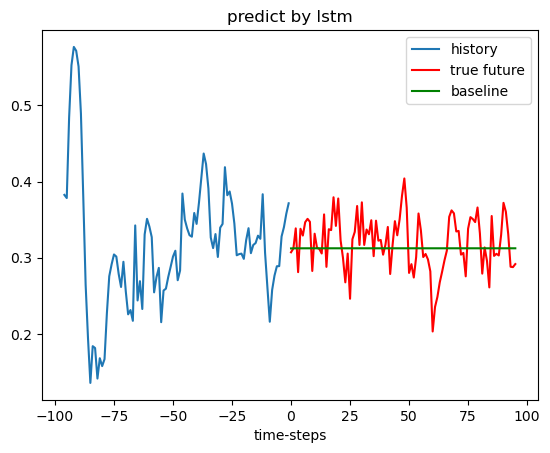

96
96
96
96
96
96
96
96
96
96
96
96
96
96
96


In [14]:
train(x_train_uni, y_train_uni, model, criterion, optimizer, n_epoch)